# ORF recognition by LSTM
LSTM can only detect short ORFs. Using simulated RNA in which the ORF takes up half the sequence, LSTM recognizes ORFs in RNA of length 100 (ORF length 50) but not RNA of length 200 (ORF length 100). Here, try RNA of length 125.


In [13]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-18 12:13:09 UTC'

In [14]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=125            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
NEURONS = 32
#DROP_RATE = 0.2
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [15]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [16]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [17]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen
def get_the_facts(seqs):
    rd = RNA_describer()
    facts = rd.get_three_lengths(seqs)
    facts_ary = np.asarray(facts) # 5000 rows, 3 columns 
    print("Facts array:",type(facts_ary))
    print("Facts array:",facts_ary.shape)
    # Get the mean of each column
    mean_5utr, mean_orf, mean_3utr = np.mean(facts_ary,axis=0)
    std_5utr, std_orf, std_3utr = np.std(facts_ary,axis=0)
    print("mean 5' UTR length:",int(mean_5utr),"+/-",int(std_5utr))
    print("mean    ORF length:",int(mean_orf), "+/-",int(std_orf))
    print("mean 3' UTR length:",int(mean_3utr),"+/-",int(std_3utr))

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
get_the_facts(pc_train)
print("Train on",len(nc_train),"NC seqs")
get_the_facts(nc_train)

Train on 20000 PC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 29 +/- 9
mean    ORF length: 64 +/- 12
mean 3' UTR length: 31 +/- 7
Train on 20000 NC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 48 +/- 25
mean    ORF length: 25 +/- 28
mean 3' UTR length: 50 +/- 24


In [18]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [19]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=ALPHABET, output_dim=ALPHABET))
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
    dnn.add(LSTM(NEURONS,return_sequences=True,input_shape=INPUT_SHAPE))
    dnn.add(LSTM(NEURONS,return_sequences=False)) 
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build() # input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (125, 4)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 125, 32)           4736      
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6908 - accuracy: 0.5208 - val_loss: 0.6757 - val_accuracy: 0.5825


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6669 - accuracy: 0.5960 - val_loss: 0.6541 - val_accuracy: 0.6146


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6445 - accuracy: 0.6325 - val_loss: 0.6298 - val_accuracy: 0.6461


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6126 - accuracy: 0.6664 - val_loss: 0.4929 - val_accuracy: 0.7797


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.4227 - accuracy: 0.8198 - val_loss: 0.3810 - val_accuracy: 0.8378


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3873 - accuracy: 0.8335 - val_loss: 0.3914 - val_accuracy: 0.8300
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3741 - accuracy: 0.8377 - val_loss: 0.3921 - val_accuracy: 0.8341
Epoch 8/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3722 - accuracy: 0.8389 - val_loss: 0.3734 - val_accuracy: 0.8379


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3701 - accuracy: 0.8348 - val_loss: 0.3606 - val_accuracy: 0.8382


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3535 - accuracy: 0.8447 - val_loss: 0.3560 - val_accuracy: 0.8416


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3557 - accuracy: 0.8415 - val_loss: 0.3508 - val_accuracy: 0.8441


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3466 - accuracy: 0.8484 - val_loss: 0.3871 - val_accuracy: 0.8316
Epoch 13/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3421 - accuracy: 0.8477 - val_loss: 0.3745 - val_accuracy: 0.8367
Epoch 14/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3323 - accuracy: 0.8569 - val_loss: 0.3340 - val_accuracy: 0.8574


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3263 - accuracy: 0.8604 - val_loss: 0.3196 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3111 - accuracy: 0.8714 - val_loss: 0.2998 - val_accuracy: 0.8788


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2879 - accuracy: 0.8834 - val_loss: 0.2764 - val_accuracy: 0.8880


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2811 - accuracy: 0.8879 - val_loss: 0.2688 - val_accuracy: 0.8935


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2703 - accuracy: 0.8956 - val_loss: 0.2833 - val_accuracy: 0.8931
Epoch 20/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2593 - accuracy: 0.9008 - val_loss: 0.2496 - val_accuracy: 0.9054


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2533 - accuracy: 0.9047 - val_loss: 0.2627 - val_accuracy: 0.9004
Epoch 22/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2542 - accuracy: 0.9024 - val_loss: 0.2399 - val_accuracy: 0.9086


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2422 - accuracy: 0.9092 - val_loss: 0.2354 - val_accuracy: 0.9086
Epoch 24/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2350 - accuracy: 0.9122 - val_loss: 0.2295 - val_accuracy: 0.9158


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2327 - accuracy: 0.9147 - val_loss: 0.2187 - val_accuracy: 0.9193


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2214 - accuracy: 0.9196 - val_loss: 0.3491 - val_accuracy: 0.8428
Epoch 27/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2181 - accuracy: 0.9204 - val_loss: 0.2624 - val_accuracy: 0.9024
Epoch 28/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2165 - accuracy: 0.9237 - val_loss: 0.2015 - val_accuracy: 0.9279


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2145 - accuracy: 0.9242 - val_loss: 0.2064 - val_accuracy: 0.9270
Epoch 30/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2014 - accuracy: 0.9290 - val_loss: 0.2351 - val_accuracy: 0.9161
Epoch 31/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2030 - accuracy: 0.9288 - val_loss: 0.2099 - val_accuracy: 0.9264
Epoch 32/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1950 - accuracy: 0.9332 - val_loss: 0.2139 - val_accuracy: 0.9258
Epoch 33/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1910 - accuracy: 0.9335 - val_loss: 0.2091 - val_accuracy: 0.9260
Epoch 34/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1937 - accuracy: 0.9342 - val_loss: 0.2208 - val_accuracy: 0.9251
Epoch 35/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1847 - accuracy: 0.9359 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1767 - accuracy: 0.9411 - val_loss: 0.1952 - val_accuracy: 0.9310
Epoch 37/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1900 - accuracy: 0.9331 - val_loss: 0.1889 - val_accuracy: 0.9320
Epoch 38/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1846 - accuracy: 0.9367 - val_loss: 0.1721 - val_accuracy: 0.9402


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1849 - accuracy: 0.9381 - val_loss: 0.2100 - val_accuracy: 0.9254
Epoch 40/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1858 - accuracy: 0.9371 - val_loss: 0.1773 - val_accuracy: 0.9406


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1721 - accuracy: 0.9420 - val_loss: 0.2374 - val_accuracy: 0.9170
Epoch 42/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1742 - accuracy: 0.9416 - val_loss: 0.1702 - val_accuracy: 0.9400
Epoch 43/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2286 - accuracy: 0.9193 - val_loss: 0.1913 - val_accuracy: 0.9319
Epoch 44/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2012 - accuracy: 0.9308 - val_loss: 0.1722 - val_accuracy: 0.9409


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1748 - accuracy: 0.9403 - val_loss: 0.1680 - val_accuracy: 0.9446


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1755 - accuracy: 0.9415 - val_loss: 0.2044 - val_accuracy: 0.9308
Epoch 47/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1679 - accuracy: 0.9430 - val_loss: 0.1842 - val_accuracy: 0.9348
Epoch 48/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2232 - accuracy: 0.9208 - val_loss: 0.1844 - val_accuracy: 0.9383
Epoch 49/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1697 - accuracy: 0.9426 - val_loss: 0.2136 - val_accuracy: 0.9270
Epoch 50/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1678 - accuracy: 0.9446 - val_loss: 0.2047 - val_accuracy: 0.9284
Fold 1, 50 epochs, 689 sec


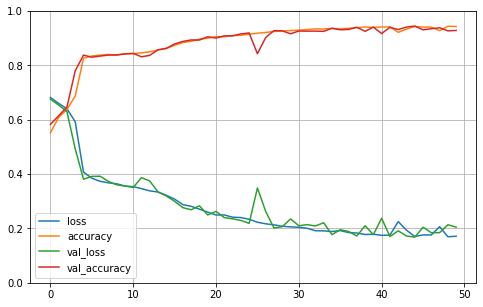

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6954 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5025 - val_loss: 0.6978 - val_accuracy: 0.5005
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6939 - accuracy: 0.5001 - val_loss: 0.6936 - val_accuracy: 0.4995
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.4989 - val_loss: 0.6937 - val_accuracy: 0.5005
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6938 - accuracy: 0.4978 - val_loss: 0.6934 - val_accuracy: 0.4995
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.693

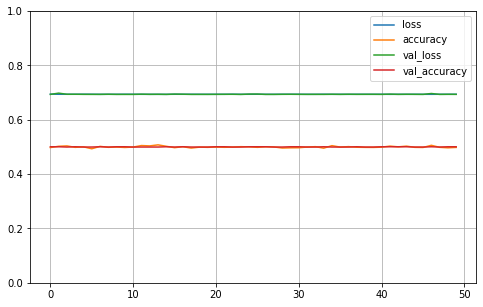

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6963 - accuracy: 0.5015 - val_loss: 0.6934 - val_accuracy: 0.4986
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5083 - val_loss: 0.6941 - val_accuracy: 0.5014
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6937 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6936 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6935 - accuracy: 0.5010 - val_loss: 0.6944 - val_accuracy: 0.4986
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.694

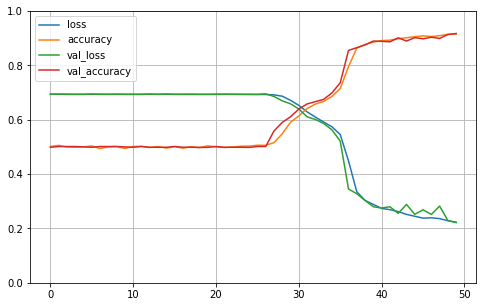

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6990 - accuracy: 0.5251 - val_loss: 0.6737 - val_accuracy: 0.5816
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6676 - accuracy: 0.5952 - val_loss: 0.6595 - val_accuracy: 0.6099
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6487 - accuracy: 0.6234 - val_loss: 0.6274 - val_accuracy: 0.6521
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6346 - accuracy: 0.6403 - val_loss: 0.6307 - val_accuracy: 0.6581
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5963 - accuracy: 0.6811 - val_loss: 0.4033 - val_accuracy: 0.8336
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.4159 - accuracy: 0.8183 - val_loss: 0.3915 - val_accuracy: 0.8345
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.388

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 47/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1810 - accuracy: 0.9380 - val_loss: 0.1922 - val_accuracy: 0.9348
Epoch 48/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1829 - accuracy: 0.9373 - val_loss: 0.2287 - val_accuracy: 0.9164
Epoch 49/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1928 - accuracy: 0.9317 - val_loss: 0.1905 - val_accuracy: 0.9389
Epoch 50/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1697 - accuracy: 0.9445 - val_loss: 0.1923 - val_accuracy: 0.9351
Fold 4, 50 epochs, 527 sec


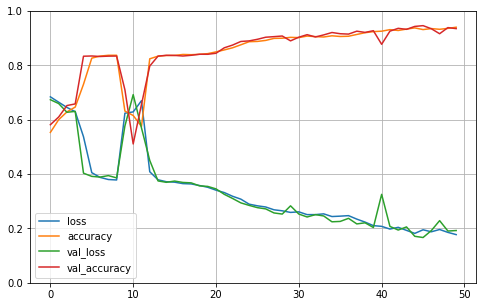

MODEL
make_DNN
input shape: (125, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6872 - accuracy: 0.5282 - val_loss: 0.6729 - val_accuracy: 0.5870
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6655 - accuracy: 0.5990 - val_loss: 0.6486 - val_accuracy: 0.6221
Epoch 3/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6377 - accuracy: 0.6382 - val_loss: 0.6392 - val_accuracy: 0.6240
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6212 - accuracy: 0.6498 - val_loss: 0.6265 - val_accuracy: 0.6438
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6140 - accuracy: 0.6545 - val_loss: 0.6097 - val_accuracy: 0.6569
Epoch 6/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6019 - accuracy: 0.6611 - val_loss: 0.5917 - val_accuracy: 0.6711
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.580

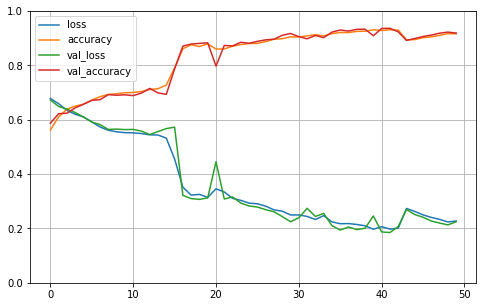

In [21]:
do_cross_validation(X,y)

In [22]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 94.85%


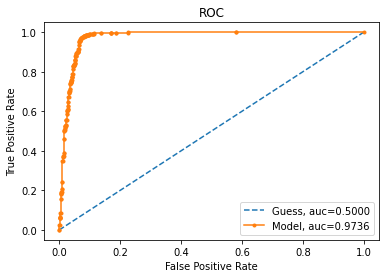

AUC: 0.97%


In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [24]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-18 12:59:44 UTC'

## Conclusion
The LSTM has variable success on simulated RNA of length 125.
That is, it learns during some rounds of cross validation, but not all.